# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Explaining-Decision-Trees-and-Random-Forests" data-toc-modified-id="Explaining-Decision-Trees-and-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explaining Decision Trees and Random Forests</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#How-Do-Decision-Trees-Work?" data-toc-modified-id="How-Do-Decision-Trees-Work?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>How Do Decision Trees Work?</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Create-Feature-Contribution" data-toc-modified-id="Create-Feature-Contribution-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create Feature Contribution</a></div><div class="lev1 toc-item"><a href="#Visualizing-Decision-Trees" data-toc-modified-id="Visualizing-Decision-Trees-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualizing Decision Trees</a></div><div class="lev1 toc-item"><a href="#Contributions" data-toc-modified-id="Contributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Contributions</a></div><div class="lev2 toc-item"><a href="#Regression-Contributions" data-toc-modified-id="Regression-Contributions-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Regression Contributions</a></div><div class="lev2 toc-item"><a href="#Decision-Tree-Features-vs.-Contributions" data-toc-modified-id="Decision-Tree-Features-vs.-Contributions-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Decision Tree Features vs. Contributions</a></div><div class="lev2 toc-item"><a href="#Extending-to-Random-Forests" data-toc-modified-id="Extending-to-Random-Forests-73"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Extending to Random Forests</a></div><div class="lev2 toc-item"><a href="#Multi-class-classification" data-toc-modified-id="Multi-class-classification-74"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Multi-class classification</a></div>

# Explaining Decision Trees and Random Forests

This notebook shows examples of how the `treeinterpreter` (<a href='https://github.com/andosa/treeinterpreter'>https://github.com/andosa/treeinterpreter</a>) library works and provides some insightful plots to gain a deeper understanding of what a decision tree or random forest is doing.

I have created a set of useful plotting functions in the file `tree_interp_functions.py`.

# Import Libraries

In [14]:
from __future__ import division

from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
import collections
from tree_interp_functions import *
from scipy.special import logit, expit
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [15]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_style('darkgrid')
sns.set_palette('colorblind')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

In [16]:
softmax = lambda x : np.exp(x)/np.sum(np.exp(x))

# How Do Decision Trees Work?

# Load Data
We will use two data sets California Housing Data and Breast Cancer Data

In [17]:
cal_housing = fetch_california_housing()
names = cal_housing.feature_names
calHousing = pd.DataFrame(cal_housing.data, columns=names)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(calHousing,
                                                        cal_housing.target,
                                                        test_size=0.2,
                                                        random_state=1)

Here, we do a simple train/test split of the data.

In [18]:
cancer_data = load_breast_cancer()
names = cancer_data.feature_names
cancerData = pd.DataFrame(cancer_data.data, columns=names)
cancerTarget = pd.DataFrame(cancer_data.target, columns=["target"])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(cancerData,
                                                        cancer_data.target,
                                                        test_size=0.2,
                                                        random_state=1)

# Build Model
Now, we build simple decision tree and random forest models. We will limit the depth of the decision tree to show how the interpretation works.

In [19]:
rf_bin_clf = RandomForestClassifier(criterion='entropy', 
                                    max_depth=4,
                                    n_estimators=1000, 
                                    random_state=0)
rf_reg = RandomForestRegressor(criterion='mse', 
                                    max_depth=4,
                                    n_estimators=1000, 
                                    random_state=0)
gbt_bin_clf = GradientBoostingClassifier(max_depth=4, 
                                         n_estimators=500, 
                                         random_state=0)

gbt_reg = GradientBoostingRegressor(max_depth=4, 
                                         n_estimators=500, 
                                         random_state=0)
rf_bin_clf.fit(X_train_c, y_train_c)
rf_reg.fit(X_train_h, y_train_h)
gbt_bin_clf.fit(X_train_c, y_train_c)
gbt_reg.fit(X_train_h, y_train_h)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [20]:
rf_stump_bin_clf = RandomForestClassifier(criterion='entropy', 
                                    max_depth=1,
                                    n_estimators=2, 
                                    random_state=0)
rf_stump_reg = RandomForestRegressor(criterion='mse', 
                                    max_depth=1,
                                    n_estimators=2, 
                                    random_state=0)
gbt_stump_bin_clf = GradientBoostingClassifier(max_depth=1, 
                                         n_estimators=500, 
                                         random_state=0)

gbt_stump_reg = GradientBoostingRegressor(max_depth=1, 
                                         n_estimators=5, 
                                         random_state=0)
rf_stump_bin_clf.fit(X_train_c, y_train_c)
rf_stump_reg.fit(X_train_h, y_train_h)
gbt_stump_bin_clf.fit(X_train_c, y_train_c)
gbt_stump_reg.fit(X_train_h, y_train_h)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, presort='auto', random_state=0, subsample=1.0,
             verbose=0, warm_start=False)

In [21]:
rf_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns,  rf_bin_clf.feature_importances_)), columns=["features", "imp"])
gbt_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns, gbt_bin_clf.feature_importances_)), columns=["features", "imp"])
rf_feature_imp_h = pd.DataFrame(list(zip(X_train_h.columns,  rf_reg.feature_importances_)), columns=["features", "imp"])
gbt_feature_imp_h = pd.DataFrame(list(zip(X_train_h.columns, gbt_reg.feature_importances_)), columns=["features", "imp"])

In [22]:
rf_stump_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns,  rf_stump_bin_clf.feature_importances_)), columns=["features", "imp"])
gbt_stump_feature_imp_c = pd.DataFrame(list(zip(X_train_c.columns, gbt_stump_bin_clf.feature_importances_)), columns=["features", "imp"])
rf_stump_feature_imp_h = pd.DataFrame(list(zip(X_train_h.columns,  rf_stump_reg.feature_importances_)), columns=["features", "imp"])
gbt_stump_feature_imp_h = pd.DataFrame(list(zip(X_train_h.columns, gbt_stump_reg.feature_importances_)), columns=["features", "imp"])

## Create Feature Contribution
We use the `ti.predict` function to get our predictions, biases, and contributions. The contributions matrix is a 3d array which represents the contribution for each example, feature, and class label.

### Stump

In [23]:
rf_stump_bin_clf_pred, rf_stump_bin_clf_bias, rf_stump_bin_clf_contrib = ti.predict(rf_stump_bin_clf, X_test_c)
gbt_stump_bin_clf_pred, gbt_stump_bin_clf_bias, gbt_stump_bin_clf_contrib = ti.predict(gbt_stump_bin_clf, X_test_c)
rf_stump_reg_pred, rf_stump_reg_bias, rf_stump_reg_contrib = ti.predict(rf_stump_reg, X_test_h)
gbt_stump_reg_pred, gbt_stump_reg_bias, gbt_stump_reg_contrib = ti.predict(gbt_stump_reg, X_test_h)

### Deep

In [24]:
rf_bin_clf_pred, rf_bin_clf_bias, rf_bin_clf_contrib = ti.predict(rf_bin_clf, X_test_c)
gbt_bin_clf_pred, gbt_bin_clf_bias, gbt_bin_clf_contrib = ti.predict(gbt_bin_clf, X_test_c)
rf_reg_pred, rf_reg_bias, rf_reg_contrib = ti.predict(rf_reg, X_test_h)
gbt_reg_pred, gbt_reg_bias, gbt_reg_contrib = ti.predict(gbt_reg, X_test_h)

In [25]:
compareGBT = list(zip(expit(gbt_bin_clf_pred), expit(gbt_bin_clf_pred)))

In [26]:
gbt_bin_clf_orig_proba = gbt_bin_clf.predict_proba(X_test_c)

In [27]:
sum_gbt = np.zeros(gbt_bin_clf_pred.shape[0])  
isFirst = True 
norm = 0
learning_rate = gbt_bin_clf.learning_rate
print(gbt_bin_clf.n_estimators)
for ii in range(gbt_bin_clf.n_estimators):
    #print(gbt_bin_clf.estimators_[ii][0].predict(X_test)[0])
    if isFirst:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test_c))
        isFirst = False
        norm += learning_rate
    else:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test_c))
        norm += learning_rate
#print("Norm: " + str(norm))
#print("Sum: " + str(sum_gbt))
#print("Sum/Norm: " + str(sum_gbt/norm))
#print("Result: " + str(expit(sum_gbt/norm)))
#print("Target: 0.67489087")

500


(-1e-08, 1e-08)

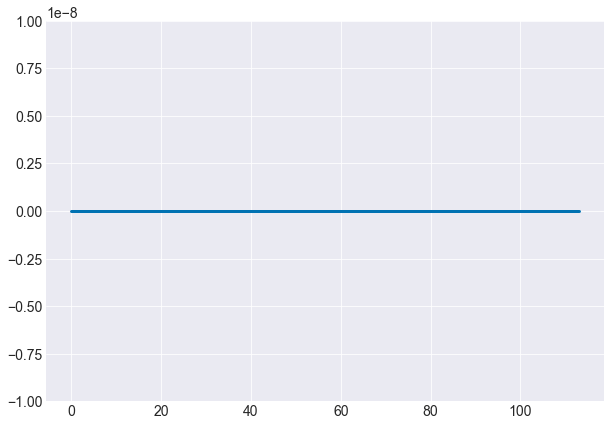

In [28]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(sum_gbt + logit(y_train_c.mean())))
plt.ylim(-0.00000001, 0.00000001)

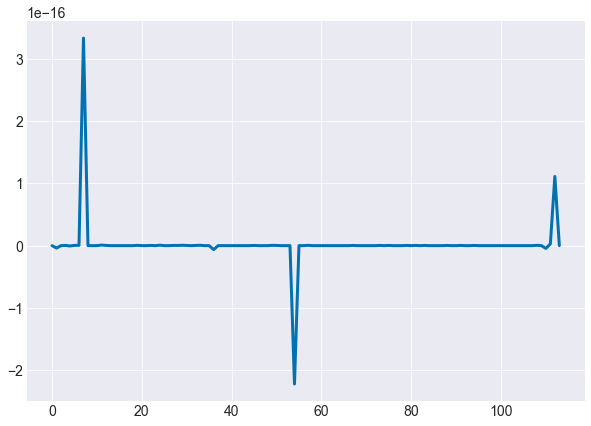

In [29]:
plt.plot(gbt_bin_clf_orig_proba[:, 1] - expit(gbt_bin_clf_pred + logit(y_train_c.mean())))

In [30]:
gbt_bin_clf_orig_proba[:, 1] - (expit(sum_gbt + logit(y_train_c.mean())))

array([ 0.00000000e+00, -3.90312782e-18,  0.00000000e+00,  3.52365706e-19,
       -5.42101086e-19,  4.06575815e-19,  4.33680869e-19,  3.33066907e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.21571847e-19,
        3.52365706e-19,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.33680869e-19,
        0.00000000e+00,  0.00000000e+00,  3.25260652e-19,  0.00000000e+00,
        7.04731412e-19,  0.00000000e+00,  0.00000000e+00,  3.25260652e-19,
        3.25260652e-19,  5.42101086e-19,  3.25260652e-19,  0.00000000e+00,
        3.25260652e-19,  5.42101086e-19,  0.00000000e+00,  0.00000000e+00,
       -6.39679282e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.25260652e-19,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.60785923e-19,  3.25260652e-19,  0.00000000e+00,
        0.00000000e+00,  

In [31]:
logit(y_test_c.mean())

0.5389965007326868

In [32]:
logit(y_train_c.mean())

0.5166907432183888

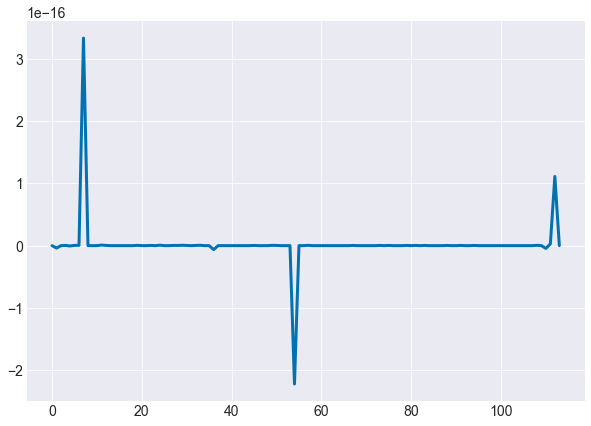

In [33]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred+ logit(y_train_c.mean())))

# Contributions

## Compare Gradient Boosted Trees to RF and DT

### Stumps

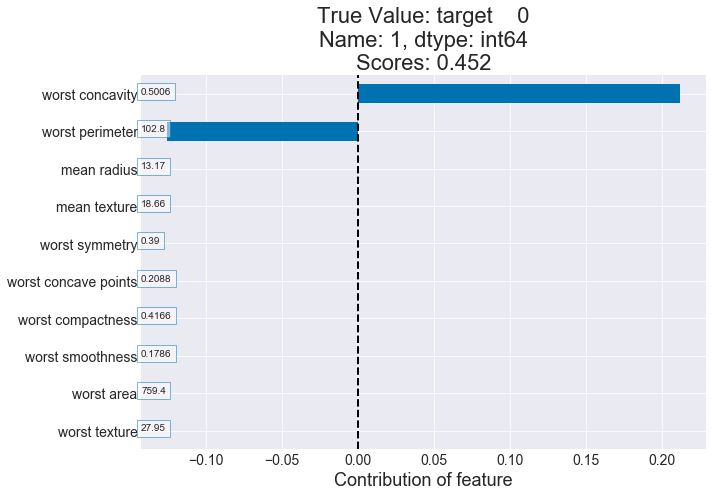

In [34]:
rf_stump_bin_contribs, true_label_rf_stump, pred_rf_stump = plot_obs_feature_contrib(rf_stump_bin_clf,
                                                   rf_stump_bin_clf_contrib,
                                                   X_test_c,
                                                   pd.DataFrame(y_test_c,columns=['target']),
                                                   1,
                                                   order_by='contribution',
                                                   num_features=10
                                                  )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

[0.934, 0.066]


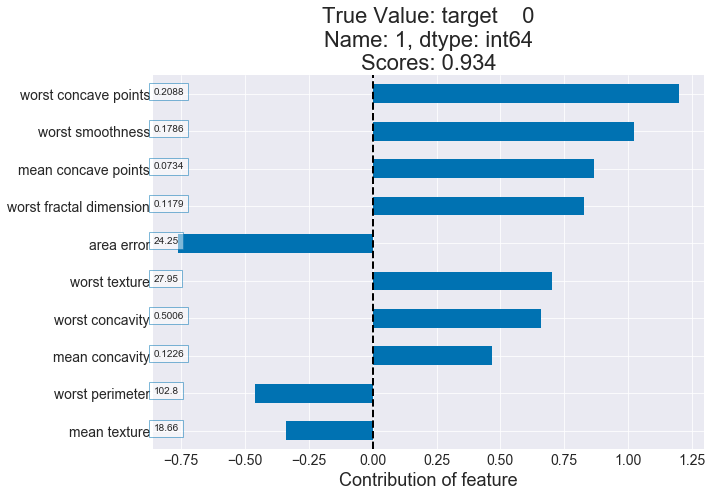

In [35]:
gbt_stump_bin_contribs, true_label_gbt_stump, pred_gbt_stump = plot_obs_feature_contrib(gbt_stump_bin_clf,
                                                gbt_stump_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=10,
                                                   neg=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

### Full Tree

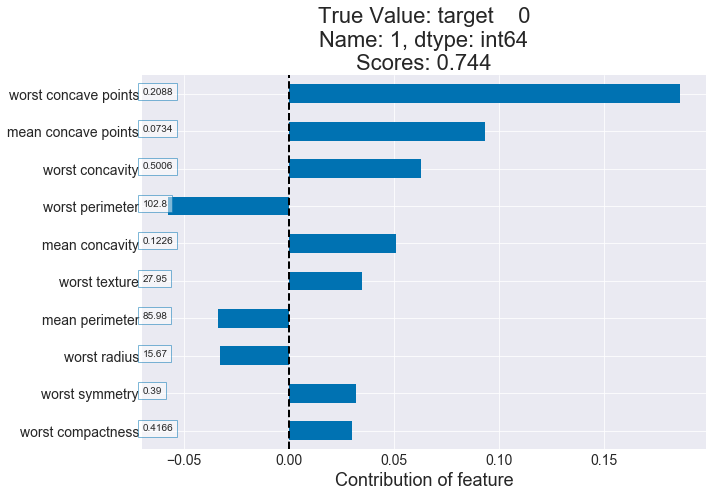

In [36]:
df2, true_label2, pred2 = plot_obs_feature_contrib(rf_bin_clf,
                                                   rf_bin_clf_contrib,
                                                   X_test_c,
                                                   pd.DataFrame(y_test_c,columns=['target']),
                                                   1,
                                                   order_by='contribution',
                                                   num_features=10
                                                  )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

[0.261, 0.739]


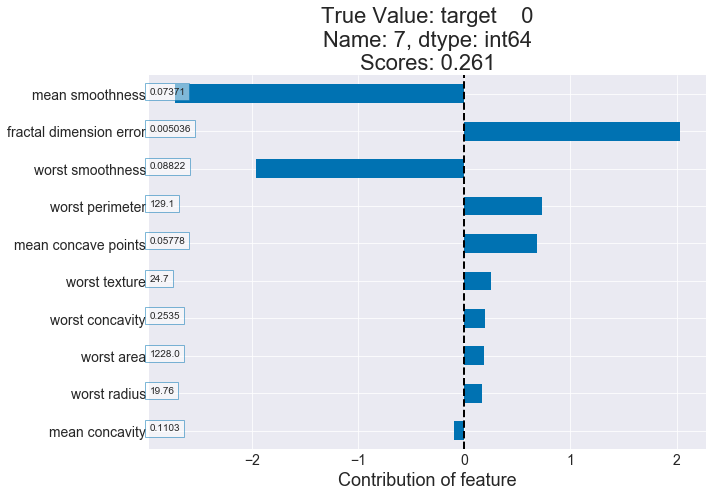

In [149]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                7,
                                                order_by='contribution',
                                                num_features=10,
                                                   neg=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

[0.0, 1.0]


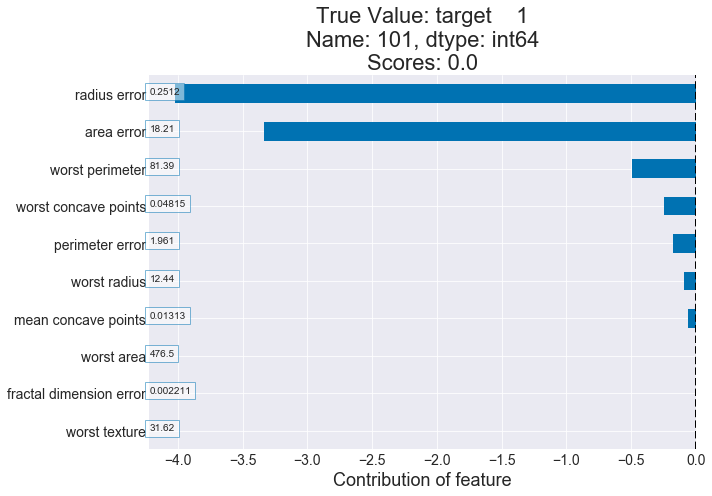

In [91]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                101,
                                                order_by='contribution',
                                                num_features=10,
                                                neg=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

In [94]:
dingus = gbt_bin_clf.predict_proba(X_test_c)

In [110]:
df2 = pd.DataFrame(dingus).sort_values(by=0)

In [112]:
df2[(df2[1] < 0.97) & (df2[1] > 0.03)]

,0,1
14,0.066405,0.933595
7,0.260531,0.739469
112,0.683793,0.316207


In [108]:
dingus[np.where((dingus>0.2) & (dingus<0.8))]

array([0.26053051, 0.73946949, 0.68379315, 0.31620685])

In [39]:
softmax(-1.0*gbt_bin_clf_contrib[1])

array([0.00426597, 0.00976493, 0.00426597, 0.00426597, 0.00426597,
       0.00426597, 0.00426597, 0.00491929, 0.00426597, 0.00426597,
       0.00426597, 0.00426597, 0.00426597, 0.01039684, 0.00426597,
       0.00426597, 0.00426597, 0.00426597, 0.00426597, 0.00426597,
       0.00426581, 0.0063404 , 0.00259865, 0.00467299, 0.00435128,
       0.00426597, 0.00426597, 0.01513121, 0.85223923, 0.00426597])

In [40]:
gbt_bin_clf_contrib[1]

array([ 0.00000000e+00, -8.28128203e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.42494634e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.90832366e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.73659243e-05, -3.96272222e-01,  4.95677503e-01, -9.11299050e-02,
       -1.97999878e-02,  0.00000000e+00,  0.00000000e+00, -1.26609043e+00,
       -5.29719798e+00,  0.00000000e+00])

In [41]:
gbt_bin_clf_bias[1]

0.009740846751323844

In [42]:
df4, true_label4, pred4 = plot_obs_feature_contrib(gbt_bin_reg,
                                                gbt_bin_reg_contrib,
                                                X_test_h,
                                                pd.DataFrame(y_test_h,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=10,
                                                   neg=True
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

NameError: name 'gbt_bin_reg' is not defined

In [ ]:
df5, true_label5, pred5 = plot_obs_feature_contrib(gbt_bin_reg,
                                                gbt_bin_reg_contrib,
                                                X_test_h,
                                                pd.DataFrame(y_test_h,columns=['target']),
                                                100,
                                                order_by='contribution',
                                                num_features=10,
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

In [43]:
gbt_reg_dot_data1 = export_graphviz(gbt_bin_reg.estimators_[1][0],
                                   out_file=None,
                                   feature_names=X_train_h.columns,
                                    filled=True,
                                    rounded=True,
                                    special_characters=True
                                  )
gbt_reg_graph1 = pydotplus.graph_from_dot_data(gbt_reg_dot_data1)
gbt_reg_graph1.write_png('plots/bin_reg_gbt1_path.png')
Image(gbt_reg_graph1.create_png())

NameError: name 'gbt_bin_reg' is not defined

In [44]:
gbt_reg_dot_data1 = export_graphviz(gbt_bin_reg.estimators_[0][0],
                                   out_file=None,
                                   feature_names=X_train_h.columns[0:8],
                                    filled=True,
                                    rounded=True,
                                    special_characters=True
                                  )
gbt_reg_graph1 = pydotplus.graph_from_dot_data(gbt_reg_dot_data1)
gbt_reg_graph1.write_png('plots/bin_reg_gbt1_path.png')
Image(gbt_reg_graph1.create_png())

NameError: name 'gbt_bin_reg' is not defined

In [45]:
XX = X_train_h
XX['target']=y_train_h


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
XX[XX.MedInc<=5.59].target.values.mean()

1.8115086011355572

In [47]:
XX[XX.MedInc<=5.12].target.values.mean()

1.7555538267120694

In [48]:
XX[XX.MedInc>5.59].target.values.mean()

3.6238883608587944

In [49]:
XX[XX.MedInc>5.124].target.values.mean()

3.369397441507141

In [50]:
1.0* XX[XX.MedInc>5.59].target.values.mean() + y_test_h.mean()

5.657276638475073

In [51]:
1.0* XX[XX.MedInc>5.124].target.values.mean()+ y_test_h.mean()

5.40278571912342

In [52]:
gbt_bin_reg_pred.mean()

NameError: name 'gbt_bin_reg_pred' is not defined

In [53]:
y_test_h.mean()

2.033388277616279

In [54]:
gbt_bin_reg.predict(X_test_h)[100]

NameError: name 'gbt_bin_reg' is not defined

In [55]:
df5.contrib.values

NameError: name 'df5' is not defined

In [56]:
y_test_h.mean()

2.033388277616279

In [57]:
expit(5+ 1.1)-expit(5)

0.004455002403008335

In [58]:
expit(5 + 1.1 + 1) - expit(6.1)

0.0014134238348780803

In [59]:
expit(1) # contrib

0.7310585786300049

In [60]:
expit(1.1)-expit(1)

0.019201526965112792

In [61]:
expit(5)-expit(2.1)

0.10240397027132819

In [62]:
test = gbt_bin_clf_contrib[1]


In [63]:
df3_imp = pd.DataFrame(gbt_bin_clf.feature_importances_, columns=["fimp"], index=X_train_c.columns)

In [64]:
df3_imp.merge(df3, left_index=True, right_index=True)

,fimp,contrib,feat_val,abs_contrib
mean radius,0.001080,0.000000,13.170000,0.000000
mean texture,0.001107,-0.828128,18.660000,0.828128
mean perimeter,0.000000,0.000000,85.980000,0.000000
mean area,0.000000,0.000000,534.600000,0.000000
mean smoothness,0.000654,0.000000,0.115800,0.000000
mean compactness,0.000042,0.000000,0.123100,0.000000
mean concavity,0.000095,0.000000,0.122600,0.000000
mean concave points,0.006600,-0.142495,0.073400,0.142495
mean symmetry,0.000044,0.000000,0.212800,0.000000
mean fractal dimension,0.000058,0.000000,0.067770,0.000000


In [65]:
df3.sort_values('proba').plot("index", "proba")

KeyError: 'proba'

In [66]:
expit(5.297198)

0.9950193312688701

In [67]:
expit(5.297198+1.266090)-0.9950193312688701

0.0035714195936755733

In [68]:
expit(1.266090)

0.7800726857136162

In [69]:
expit(sum(df3.contrib.values*-1))

0.9997831810109253

### Stump

# Random ordering of contributions

In [70]:
from random import sample

In [114]:
from random import shuffle
x = list(range(test.size))
testVals = -1.0 * df3.contrib.values
contrib0 = np.zeros(len(x))
contrib1 = np.zeros(len(x))
contrib2 = np.zeros(len(x))
contrib3 = np.zeros(len(x))
contrib4 = np.zeros(len(x))


In [222]:
contrib0 = np.zeros(len(x))

for ii in range(30):
    y = sample(x, len(x))
    sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
    prevVal = expit(sumContrib)
    for jj in y:
        sumContrib +=  testVals[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib0[jj]+=val
    

In [223]:
contrib1 = np.zeros(len(x))

for ii in range(60):
    y = sample(x, len(x))
    sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
    prevVal = expit(sumContrib)
    for jj in y:
        sumContrib +=  testVals[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib1[jj]+=val

In [224]:
contrib2 = np.zeros(len(x))

for ii in range(900):
    y = sample(x, len(x))
    sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
    prevVal = expit(sumContrib)
    for jj in y:
        sumContrib +=  testVals[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib2[jj]+=val

In [118]:
df3['proba']=(contrib2/900)

In [119]:
gbt_bin_clf.feature_importances_

array([1.07983879e-03, 1.10731945e-03, 0.00000000e+00, 0.00000000e+00,
       6.54157433e-04, 4.23813347e-05, 9.45148156e-05, 6.59992881e-03,
       4.39991678e-05, 5.81052289e-05, 5.55844267e-03, 4.37140132e-04,
       3.98380282e-04, 5.71961507e-03, 5.96510363e-05, 1.90395436e-03,
       1.14801982e-04, 2.95056477e-03, 1.00600201e-04, 3.99312699e-04,
       4.37926863e-03, 1.29870078e-02, 9.78199291e-02, 8.18879533e-03,
       6.70951794e-04, 1.14183097e-03, 5.32463801e-04, 1.12680232e-02,
       1.68902119e-03, 0.00000000e+00])

In [225]:
contrib3 = np.zeros(len(x))

for ii in range(100000):
    y = sample(x, len(x))
    sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
    prevVal = expit(sumContrib)
    #print(sumContrib)
    #print(prevVal)
    for jj in y:
        sumContrib +=  testVals[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib3[jj]+=val

In [201]:
np.sum(contrib3)/100000+0.3713495468645612

0.2605305124683878

-0.5264315899697126
0.3713495468645612


In [226]:
contrib4 = np.zeros(len(x))

for ii in range(400000):
    y = sample(x, len(x))
    sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
    prevVal = expit(sumContrib)
    #print(sumContrib)
    #print(prevVal)
    for jj in y:
        sumContrib +=  testVals[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib4[jj]+=val

In [218]:
sumContrib = -1.0 * gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean())
prevVal = expit(sumContrib)
print(np.sum(contrib0/30) + prevVal - gbt_bin_clf_orig_proba[idxTest][0])
print(np.sum(contrib1/60) + prevVal - gbt_bin_clf_orig_proba[idxTest][0])
print(np.sum(contrib2/900) + prevVal - gbt_bin_clf_orig_proba[idxTest][0])
print(np.sum(contrib3/100000) + prevVal - gbt_bin_clf_orig_proba[idxTest][0])
print(np.sum(contrib4/400000) + prevVal - gbt_bin_clf_orig_proba[idxTest][0])

2.220446049250313e-16
3.885780586188048e-16
1.5543122344752192e-15
-6.566969190657801e-14
-4.785616347646737e-13


-0.11081903439658625

In [148]:
gbt_bin_clf_pred[idxTest]


0.526522292405387

In [132]:
idxTest = 7
calcProba = 1.0 - expit((gbt_bin_clf_pred[idxTest] + logit(y_train_c.mean())))

print("         y_mean: " + str(y_train_c.mean()))
print("  logit(y_mean): " + str(logit(y_train_c.mean())))
print("          pred2: " + str(gbt_bin_clf_pred[idxTest]))
print("          origP: " + str(gbt_bin_clf_orig_proba[idxTest][0]))
print("        1-origP: " + str(gbt_bin_clf_orig_proba[idxTest][1]))
print("         calcP : " + str(calcProba))
print("logit(calcProb): " + str(logit(calcProba)))
#print(gbt_bin_clf_contrib[0])
print("    sum contrib: " + str(gbt_bin_clf_contrib[idxTest].sum()))
print("           bias: " + str(gbt_bin_clf_bias[idxTest]))
print("sum contrib + b: " + str(gbt_bin_clf_contrib[idxTest].sum() + gbt_bin_clf_bias[0]))
print("          Label: " + str(y_test_c[idxTest]))

print("sum(contrib) + b = prediction")
print("expit( prediction + logit(y_mean)) = proba")

         y_mean: 0.6263736263736264
  logit(y_mean): 0.5166907432183888
          pred2: 0.526522292405387
          origP: 0.2605305124684535
        1-origP: 0.7394694875315465
         calcP : 0.2605305124684538
logit(calcProb): -1.0432130356237759
    sum contrib: 0.5167814456540628
           bias: 0.009740846751323844
sum contrib + b: 0.5265222924053866
          Label: 0
sum(contrib) + b = prediction
expit( prediction + logit(y_mean)) = proba


In [180]:
myPrediction = df3.contrib.values.sum() + gbt_bin_clf_bias[0]

In [181]:
expit(-1.0 * myPrediction + logit(1.0 - y_train_c.mean()))

0.2605305124684539

In [185]:
expit(-1.0*df3.contrib.values.sum() - gbt_bin_clf_bias[7] + logit(1.0 - y_train_c.mean()))

0.2605305124684539

In [138]:
prevVal

0.25811712100571244

IndentationError: unexpected indent (<ipython-input-121-ad2bbad905e2>, line 2)

In [230]:
print(contrib0/30)
print(contrib1/60)
print(contrib2/900)
print(contrib3/100000)
print(contrib4/400000)


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.30623128e-06
 -1.00560412e-05  8.92625706e-06 -8.74009934e-03  1.09737119e-02
 -1.60899594e-02  2.33840211e-02  2.93698836e-02  3.65336461e-02
  4.22798397e-02  1.03534283e-01  1.08606533e-01 -3.74595738e-01
  3.11573526e-01 -3.77653859e-01]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.22390536e-06
 -9.08322172e-06  9.91616470e-06 -8.52136808e-03  9.90226058e-03
 -1.59578330e-02  2.67222692e-02  3.01546846e-02  3.17584722e-02
  3.85452826e-02  1.03423280e-01  1.21034295e-01 -3.13406924e-01
  3.15478396e-01 -4.49958908e-01]
[ 0.00000000e+00  0.00

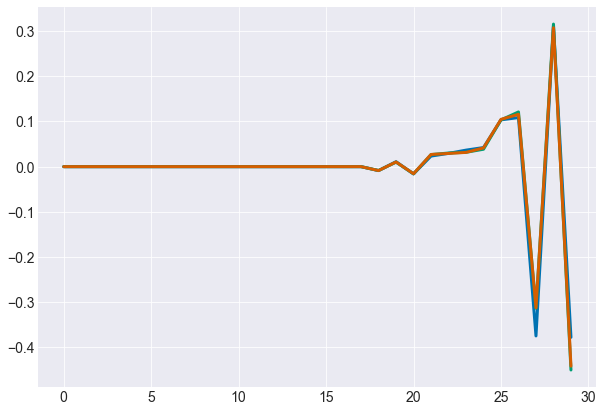

In [234]:
plt.plot(contrib0/30)
plt.plot(contrib1/60)
plt.plot(contrib2/900)

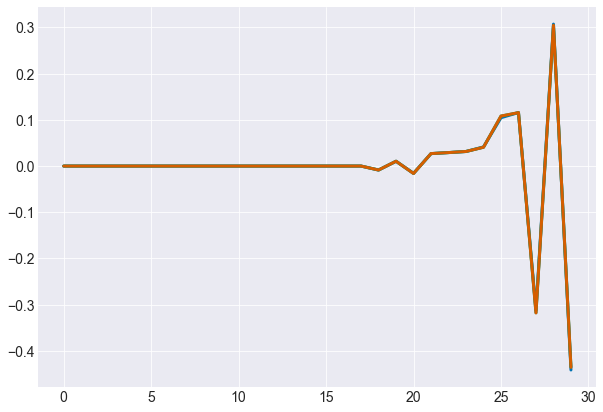

In [232]:
plt.plot(contrib2/900)
plt.plot(contrib3/100000)
plt.plot(contrib4/400000)


In [125]:
np.sum(contrib3/100000.0)

-0.12602541198987977

In [128]:
logit(y_test_c.mean())

0.5389965007326868

0.6018000757676194

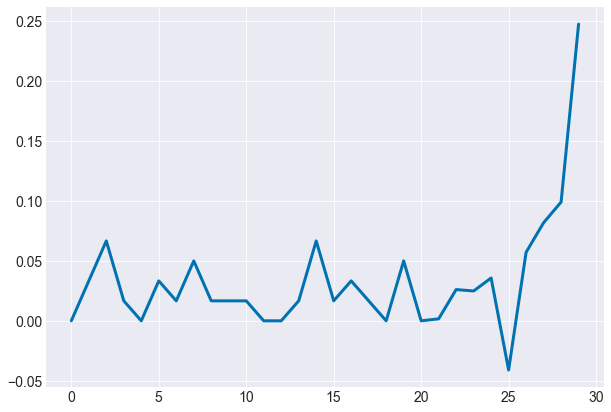

In [81]:
plt.plot(contrib0/30)


In [ ]:
plt.plot(contrib1/60)


In [ ]:
plt.plot(contrib2/900)


In [ ]:
plt.plot((contrib2/900)/(contrib3/8000000))
plt.plot((contrib4/4000000)/(contrib3/8000000))



In [ ]:
print("     30: " + str(np.sum(contrib0/30)))
print("     60: " + str(np.sum(contrib1/60)))
print("    900: " + str(np.sum(contrib2/900)))
print("4000000: " + str(np.sum(contrib4/4000000)))
print("8000000: " + str(np.sum(contrib3/8000000)))


In [ ]:
1-expit(gbt_bin_clf_contrib[1].sum()+gbt_bin_clf_bias[1] + logit(y_test_c.mean()))

In [ ]:
gbt_bin_clf_orig_proba[1][0]

In [ ]:
gbt_bin_clf_bias[0]

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [ ]:
softmax(gbt_bin_clf_contrib[1])

In [ ]:
print(logit(y_test_c.mean()))
print(y_test_c.mean())

In [ ]:
logit(0.5)

In [ ]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test_c,
                                                pd.DataFrame(y_test_c,columns=['target']),
                                                1,
                                                order_by='contribution',
                                                num_features=100                                                                
                                    )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

## Regression Contributions

In [ ]:
idxTest = 1
calcProba = 1.0 - expit((gbt_bin_clf_pred[idxTest] + logit(y_train_c.mean())))

print("         y_mean: " + str(y_train_c.mean()))
print("  logit(y_mean): " + str(logit(y_train_c.mean())))
print("          pred2: " + str(gbt_bin_clf_pred[idxTest]))
print("          origP: " + str(gbt_bin_clf_orig_proba[idxTest][0]))
print("         calcP : " + str(calcProba))
print("logit(calcProb): " + str(logit(calcProba)))
#print(gbt_bin_clf_contrib[0])
print("    sum contrib: " + str(gbt_bin_clf_contrib[idxTest].sum()))
print("           bias: " + str(gbt_bin_clf_bias[idxTest]))
print("sum contrib + b: " + str(gbt_bin_clf_contrib[idxTest].sum() + gbt_bin_clf_bias[0]))
print("          Label: " + str(y_test_c[idxTest]))

print("sum(contrib) + b = prediction")
print("expit( prediction + logit(y_mean)) = proba")

In [ ]:
gbt_bin_clf_contrib[1]

In [ ]:
gbt_bin_clf_bias[0]

In [ ]:
-1*gbt_bin_clf_contrib[1].sum()

In [ ]:
gbt_bin_clf_bias[0]

In [ ]:
logit(0.9997831810024064)

In [ ]:
foo = gbt_bin_clf_contrib.sum(axis=1)
print(foo.shape)
print(foo)
print(expit(foo[0] - gbt_bin_clf_bias[0]))
print(gbt_bin_clf_bias[0])
print(logit(gbt_bin_clf_bias[0]))

In [ ]:
rf_bin_clf.predict_proba(X_test_c)

In [ ]:
gbt_bin_clf_contrib[5]

In [ ]:
expit(gbt_bin_clf_contrib[5])

In [ ]:
gbt_bin_clf_bias

In [ ]:
FirstSplit = X_train_c[X_train_c['worst perimeter']<=106.05]

In [ ]:
SecondSplit = FirstSplit[FirstSplit['worst concave points']<=0.16]

In [ ]:
yT = pd.DataFrame(y_train_c,columns=['target'], index=X_train_c.index)

In [ ]:
trueY = pd.DataFrame(gbt_bin_clf.predict(X_train_c), columns=['target'], index=X_train_c.index)

In [ ]:
np.sqrt((yT.loc[FirstSplit.index, 'target'].values-trueY.loc[FirstSplit.index, 'target'].values).sum()**2)/271

In [ ]:
170/285

In [ ]:
yT['target'].value_counts()

In [ ]:
262.0/271.0*np.log(262.0/271.0) + 9./271.0 * np.log(9./271.0)

In [ ]:
expit(0.472)

In [ ]:
ml = 0.967 
mr = 0.125
diff = ml - mr
nl = 271 
nr = 184
I = nl * nr * diff**2 /(nl + nr)

In [ ]:
gbt_bin_clf.predict_proba(X_test_c)

In [ ]:
mod = gbt_bin_clf.estimators_[0][0]
expit(0.1* mod.predict(X_test_c))
logit(gbt_bin_clf.predict_proba(X_test_c)[:,1])-(0.1* mod.predict(X_test_c))
expit(0.51669074)


In [ ]:
gbt_bin_clf.predict_proba(X_test_c)[:,1]- expit(0.1* mod.predict(X_test_c)+0.51669074)

In [ ]:
gbt_clf_dot_data0 = export_graphviz(gbt_bin_clf.estimators_[0][0],
                                    out_file=None,
                                    feature_names=X_train_c.columns,
                                    filled=True, rounded=True,
                                    special_characters=True
                                    )
gbt_clf_graph0 = pydotplus.graph_from_dot_data(gbt_clf_dot_data0)
gbt_clf_graph0.write_png('plots/bin_clf_gbt0_path.png')
Image(gbt_clf_graph0.create_png())

In [ ]:
gbt_clf_dot_data1 = export_graphviz(gbt_bin_clf.estimators_[1][0],
                                    out_file=None,
                                    feature_names=X_train_c.columns,
                                    filled=True,
                                    rounded=True,
                                    special_characters=True
                                  )
gbt_clf_graph1 = pydotplus.graph_from_dot_data(gbt_clf_dot_data1)
gbt_clf_graph1.write_png('plots/bin_clf_gbt1_path.png')
Image(gbt_clf_graph1.create_png())

In [ ]:
rf_clf_dot_data0 = export_graphviz(rf_bin_clf.estimators_[0],
                                   out_file=None,
                                   feature_names=X_train_c.columns,
                                   filled=True, 
                                   rounded=True,
                                   special_characters=True
                                  )
rf_clf_graph0 = pydotplus.graph_from_dot_data(rf_clf_dot_data0)
rf_clf_graph0.write_png('plots/bin_clf_rf0_path.png')
Image(rf_clf_graph0.create_png())

In [ ]:
rf_clf_dot_data1 = export_graphviz(rf_bin_clf.estimators_[1],
                                   out_file=None,
                                   feature_names=X_train_c.columns,
                                   filled=True,
                                   rounded=True,
                                   special_characters=True
                                  )
rf_clf_graph1 = pydotplus.graph_from_dot_data(rf_clf_dot_data1)
rf_clf_graph1.write_png('plots/bin_clf_rf1_path.png')
Image(rf_clf_graph1.create_png())

In [ ]:
X_train_c.columns

In [ ]:
print('Convenience plot with ``partial_dependence_plots``')
names = X_train_c.columns
features = [10, 27, 28, 22, (5, 1)]
fig, axs = plot_partial_dependence(gbt_bin_clf, X_train_c, features,
                                   feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('Custom 3d plot via ``partial_dependence``')
fig = plt.figure()

target_feature = (27, 22)
pdp, axes = partial_dependence(gbt_bin_clf, target_feature,
                               X=X_train_c, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence cancer on worst\n'
             'symmetry and worst concave points')
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:
X_test_c.iloc[0]

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
X_train_c.as_matrix()

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_c.as_matrix(), feature_names=X_train_c.columns, class_names=["neg", "pos"], discretize_continuous=True, kernel_width=3)


In [ ]:
exp = explainer.explain_instance(X_test_c.as_matrix()[1], gbt_bin_clf.predict_proba, num_features=10, top_labels=1)

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
exp_rf = explainer.explain_instance(X_test_c.as_matrix()[1], rf_bin_clf.predict_proba, num_features=10, top_labels=1)

In [ ]:
exp_rf.show_in_notebook(show_table=True, show_all=False)


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_h.as_matrix(), feature_names=X_train_h.columns[0:8], discretize_continuous=True, kernel_width=3)
exp = explainer.explain_instance(X_test_h.as_matrix()[1], gbt_bin_reg.predict, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
target_temp = np.zeros(1000)
target_temp[0:250]= np.ones(250) 
target = target_temp.astype(int) & np.random.randint(0,2, 1000)
f1 = np.zeros(1000)
f1[0:500]=np.ones(500)
f2 = np.zeros(1000)
f2[0:250]= np.ones(250)
f2[500:750]=np.ones(250)

In [ ]:
fake_data = pd.DataFrame(list(zip(f1, f2)), columns=["f1", "f2"])


In [ ]:
gbt_bin_clf2 = GradientBoostingClassifier(max_depth=2, 
                                         n_estimators=10, 
                                         random_state=0)

In [ ]:
gbt_bin_clf2.fit(fake_data, target)

In [ ]:
target.mean()

In [ ]:
gbt_clf_dot_data_22 = export_graphviz(gbt_bin_clf2.estimators_[2][0],
                                   out_file=None,
                                   feature_names=["F1", "F2"]
                                  )
gbt_clf_graph_22 = pydotplus.graph_from_dot_data(gbt_clf_dot_data_22)
#gbt_clf_graph0.write_png('plots/bin_clf_gbt0_path.png')
Image(gbt_clf_graph_22.create_png())

In [ ]:
gbt_bin_clf_pred2, gbt_bin_clf_bias2, gbt_bin_clf_contrib2 = ti.predict(gbt_bin_clf2, fake_data)

In [ ]:
df2, true_label2, pred2 = plot_obs_feature_contrib(gbt_bin_clf2,
                                                   gbt_bin_clf_contrib2,
                                                   fake_data,
                                                   pd.DataFrame(target,columns=['target']),
                                                   1,
                                                   order_by='contribution',
                                                   num_features=2
                                                  )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

In [ ]:
df2, true_label2, pred2 = plot_obs_feature_contrib(gbt_bin_clf2,
                                                   gbt_bin_clf_contrib2,
                                                   fake_data,
                                                   pd.DataFrame(target,columns=['target']),
                                                   500,
                                                   order_by='contribution',
                                                   num_features=2
                      0
                                                  .)00
0.
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

In [ ]:
testVals22 = gbt_bin_clf_contrib2[0]
x = list(range(2))
print(testVals22)

In [ ]:
contrib22 = np.zeros(2)
for ii in range(100000):
    y = sample(x, len(x))
    sumContrib = 0
    prevVal = 0
    for jj in y:
        sumContrib +=  testVals22[jj]
        val = expit(sumContrib) - prevVal
        prevVal = expit(sumContrib) 
        contrib22[jj]+=val

In [ ]:
contrib22/100000

In [ ]:
np.random.randint(0,2, 1000)&np.random.randint(0,2, 1000)

In [ ]:
np.zeros(10)